## 0. Content

* [1. Loading and Visualizing data](#section1)
* [2. Solving Hard Margin SVM Dual Problem](#section2)
    * [2.1. Examine the result](#section2.1)
    * [2.2. Solving the roots of Hard Margin SVM Primal Problem](#section2.2)
    * [2.3. Plotting the result](#section2.3)
* [3. Solving Hard Margin SVM Primal Problem](#section3)
* [4. Solving Hard Margin SVM with sklearn](#section4)
    * [4.1. Plotting the result with different Cs](#section4.1)
* [5. References](#section5)

In [110]:
import numpy as np
import matplotlib.pyplot as plt

<a id='section1'></a>
## 1. Loading and Visualizing data

In [111]:
# Just a simple 2D data
data = np.loadtxt('../data/data7.txt', delimiter = ',')

m = data.shape[0]  # Number of training examples

y = data[:, np.newaxis, 2]

X = data[:, 0:2]
X0 = X[np.where(y == 0)[0], :]  # Class 0 (not feature!)
X1 = X[np.where(y == 1)[0], :]  # Class 1

# Figure number
fignum = 1

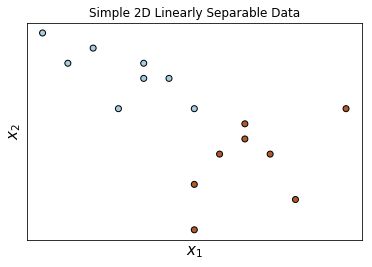

In [113]:
plt.figure(fignum)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Paired, edgecolors = 'k')
plt.xlabel('$x_1$', fontsize = 15)
plt.ylabel('$x_2$', fontsize = 15)
plt.xticks(())
plt.yticks(())
plt.title('Simple 2D Linearly Separable Data')
plt.show()

fignum = 2

<a id='section2'></a>
## 2. Solving Hard Margin SVM Dual Problem

SVM Dual Problem is a Quadratic Programming, we can solve this with [CVXOPT](http://cvxopt.org/) (Python Software For Convex Optimization):

<a href="https://www.codecogs.com/eqnedit.php?latex=(\lambda)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\lambda^{T}&space;P&space;\lambda&space;&plus;&space;(-1)^{T}\lambda&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;\left\{\begin{matrix}&space;y^{T}\lambda&space;=&space;0&space;\\&space;\lambda&space;\geq&space;0&space;\end{matrix}\right." target="_blank"><img src="https://latex.codecogs.com/gif.latex?(\lambda)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\lambda^{T}&space;P&space;\lambda&space;&plus;&space;(-1)^{T}\lambda&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;\left\{\begin{matrix}&space;y^{T}\lambda&space;=&space;0&space;\\&space;\lambda&space;\geq&space;0&space;\end{matrix}\right." title="(\lambda) = argmin ~ \frac{1}{2} \lambda^{T} P \lambda + (-1)^{T}\lambda \newline \newline ~\hspace{45pt} subject ~ to: \left\{\begin{matrix} y^{T}\lambda = 0 \\ \lambda \geq 0 \end{matrix}\right." /></a>

The name of the matrices is according to the official documentation of CVXOPT on Quadratic Programming: [link](http://cvxopt.org/userguide/coneprog.html#quadratic-programming).

In [114]:
from cvxopt import matrix, solvers

In [115]:
# Map 0 to -1
y[np.where(y == 0)[0], 0] = -1

# Build the Quadratic Coefficient Matrix P
V = np.concatenate((-X0, X1), axis = 0)
P = matrix(V.dot(V.T))

q = matrix(-np.ones((m, 1)))
# Matrices for the equality constraint
A = matrix(np.reshape(y.T, (1, m)))
b = matrix(np.zeros((1, 1)))
# Matrices for the unequality constraint (lambda >= 0)
G = matrix(-np.eye(m))
h = matrix(np.zeros((m, 1)))  # G*lambda <= h; so with given G, h: lambda >= 0

solvers.options['show_progress'] = False
sol = solvers.qp(P, q, G, h, A, b)  # Solve the Quadratic Programming

<a id='section2.1'></a>
### 2.1. Examine the result

In [116]:
l = np.array(sol['x'])
print('lambda = ')
print(l.T)

lambda = 
[[  1.59999998e+00   1.93985296e-09   1.29330228e-09   6.46651145e-10
    1.29343877e-09   1.10851193e-09   5.96927966e-10   4.56465238e-10
    1.10871283e-09   1.59950601e+00   8.62142125e-10   1.93985296e-09
    3.39909447e-04   7.75823699e-09   1.54049256e-04   2.58511819e-09]]


We can observe there are 4 lambda values which aren't equal to 0, hence there are 4 support vectors.

<a id='section2.2'></a>
### 2.2. Solving the roots of Hard Margin SVM Primal Problem

In [117]:
epsilon = 1e-6  # Need this since we're working on float numbers
S = np.where(l > epsilon)[0]  # Support set: a set of support vectors

VS = V[S, :]
XS = X[S, :]
yS = y[S, :]
lS = l[S]

# Calculate w and b
w = lS.T.dot(VS)
b = np.mean(yS.T - w.dot(XS.T))

print('w = ', w)
print('b = ', b)

w =  [[ 1.59967597 -0.800648  ]]
b =  1.39971648323


<a id='section2.3'></a>
### 2.3. Plotting the result

In [118]:
def plot_result(X, y, w, b, XS, C, C_title = True):
    global fignum
    
    plt.figure(fignum)
    if C_title:
        plt.title('Result with C = %f' % C)
    # Plot the data
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Paired, edgecolors = 'k')
    
    # Plot the separable line
    x1_min, x1_max = np.min(X[:, 0]), np.max(X[:, 0])
    x1 = np.linspace(x1_min, x1_max, endpoint = True)
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x2 = slope * x1 + intercept
    plt.plot(x1, x2, color = 'blue')
    
    # Plot the margin
    margin = 1 / np.sqrt(np.sum(w ** 2))
    x2_down = x2 - np.sqrt(1 + slope ** 2) * margin
    x2_up = x2 + np.sqrt(1 + slope ** 2) * margin
    plt.plot(x1, x2_down, 'k--', color = 'blue')
    plt.plot(x1, x2_up, 'k--', color = 'blue')
    
    # Circle around support vectors
    plt.plot(XS[:, 0], XS[:, 1], 'ro', fillstyle = 'none', markersize = 11)

    plt.axis('tight')
    x2_min, x2_max = np.min(X[:, 1]), np.max(X[:, 1])
    eps = 0.4
    plt.xlim(x1_min - eps, x1_max + eps)
    plt.ylim(x2_min - eps, x2_max + eps)
    
    plt.xticks(())
    plt.yticks(())
    plt.xlabel('$x_1$', fontsize = 15)
    plt.ylabel('$x_2$', fontsize = 15)

    plt.show()
    
    fignum = fignum + 1

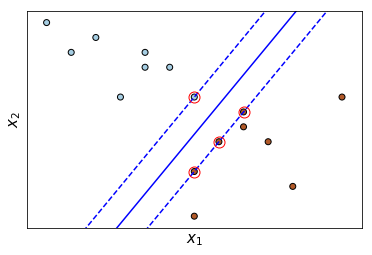

In [119]:
plot_result(X, y, w[0], b, XS, 0, C_title = False)

<a id='section3'></a>
## 3. Solving Hard Margin SVM Primal Problem

The SVM Primal Problem is maximizing the margin for the separable line:

<a href="https://www.codecogs.com/eqnedit.php?latex=(w,&space;b)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\left&space;\|&space;w&space;\right&space;\|^{2}_{2}&space;=&space;argmin&space;\frac{1}{2}&space;w^{T}Iw&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;1&space;-&space;y_{n}(w^{T}x_{n}&plus;b)&space;\leq&space;0" target="_blank"><img src="https://latex.codecogs.com/gif.latex?(w,&space;b)&space;=&space;argmin&space;~&space;\frac{1}{2}&space;\left&space;\|&space;w&space;\right&space;\|^{2}_{2}&space;=&space;argmin&space;\frac{1}{2}&space;w^{T}Iw&space;\newline&space;\newline&space;~\hspace{45pt}&space;subject&space;~&space;to:&space;1&space;-&space;y_{n}(w^{T}x_{n}&plus;b)&space;\leq&space;0" title="(w, b) = argmin ~ \frac{1}{2} \left \| w \right \|^{2}_{2} = argmin \frac{1}{2} w^{T}Iw \newline \newline ~\hspace{45pt} subject ~ to: 1 - y_{n}(w^{T}x_{n}+b) \leq 0" /></a>

This is also a Quadractic Programming and we can use CVXOPT again to solve it.

<a id='section4'></a>
## 4. Solving Hard Margin SVM with sklearn

The complete form of SVM Objective Function (Soft Margin SVM's form):

<a href="https://www.codecogs.com/eqnedit.php?latex=(w,&space;b,&space;\xi&space;)&space;=&space;\frac{1}{2}\left&space;\|&space;w&space;\right&space;\|^{2}&space;&plus;&space;C\sum_{i=1}^{n}&space;\xi_{i}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?(w,&space;b,&space;\xi&space;)&space;=&space;\frac{1}{2}\left&space;\|&space;w&space;\right&space;\|^{2}&space;&plus;&space;C\sum_{i=1}^{n}&space;\xi_{i}" title="(w, b, \xi ) = \frac{1}{2}\left \| w \right \|^{2} + C\sum_{i=1}^{n} \xi_{i}" /></a>

The data we are handling is very well behaved, e.g. we can always find a straight line to perfectly separate the data into 2 parts. Therefore we can ignore the second term in the above formula, the error term, to evaluate the error; and just apply the Hard Margin SVM with C = 0. This is exactly what we've just done in section 2 and 3.

Hard Margin SVM will try to give us a separating line with **largest margin** and **0 error on the data** if possible.

Now we will solve the problem using sklearn package with various values of C to understand the nature of the 2 terms in the formula.

Note: Since the error term appears in the Objective Function, there are now 2 kinds of support vector:
   * **Margin support vector**: the points lie on the separating line.
   * **Non margin support vector**: the points lie between 2 margins of the separating line.

In [120]:
from sklearn.svm import SVC

In [121]:
def train_svm(X, y, C):
    y = y.reshape((m,))
    
    clf = clf = SVC(kernel = 'linear', C = C)  # Try various values of C.
        
    clf.fit(X, y)
    
    return clf

<a id='section4.1'></a>
### 4.1. Plotting the result with different Cs

What does a (very) small value of C tell us?
   * C small makes the term (C * error) small, the algorithm therefore doesn't need to minimize the error much.
   * As a result, this causes the algorithm to look for a larger-margin separating line (e.g. focus on minimizing the first term), even if that line misclassifies more points. **This could lead to underfitting.**
   
Conversely:
   * Large values of C make the term (C * error) large, the algorithm therefore focus on minimizing the error (e.g. get the training points classified correctly).
   * The separating line now may have a smaller-margin. **This could lead to overfitting.**

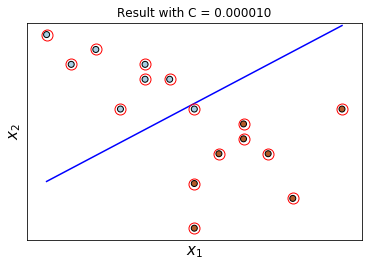

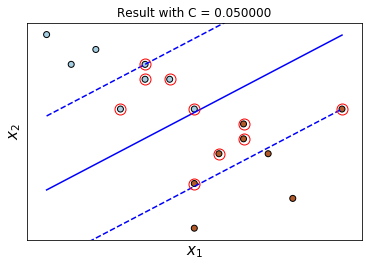

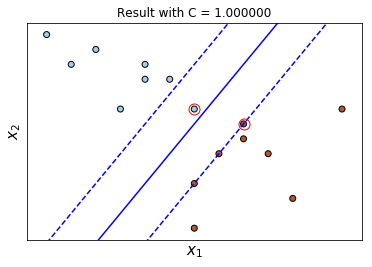

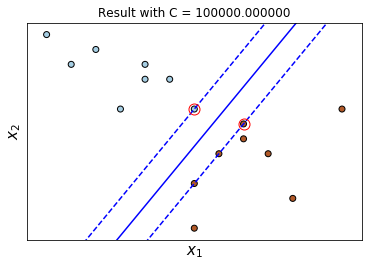

In [122]:
for C in (1e-5, 5e-2, 1, 1e5):
    clf = train_svm(X, y, C)
    w = clf.coef_[0]
    b = clf.intercept_
    XS = clf.support_vectors_
    
    plot_result(X, y, w, b, XS, C)

<a id='section5'></a>
## 5. References

[[1] CVXOPT](http://cvxopt.org/)

[[2] machinelearningcoban.com](https://machinelearningcoban.com/)
